# Find the best location to open a fast food restaurant in New York
Couresa Data Science Course Final Assignment - Capstone Project
**************

In [93]:
# import libs
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim

import folium 
from folium.features import CustomIcon
from folium.plugins import MarkerCluster

import foursquare
from pandas.io.json import json_normalize

from pathlib import Path

from sklearn.cluster import KMeans
from sklearn import preprocessing


import matplotlib.cm as cm
import matplotlib.colors as colors

Download from https://streeteasy.com/blog/data-dashboard/?agg=Total&metric=Inventory&type=Rentals&bedrooms=Any%20Bedrooms&property=Any%20Property%20Type&minDate=2010-01-01&maxDate=2020-10-01&area=Flatiron,Brooklyn%20Heights

In [2]:
#load the rent dataset for one bedroom
neighborhood_rent = pd.read_csv("./medianAskingRent_OneBd.csv")

neighborhood_rent = neighborhood_rent[neighborhood_rent['areaType'] == 'neighborhood' ]
neighborhood_rent['Borough'] = neighborhood_rent['Borough'].apply(lambda name : name.upper())
neighborhood_rent['areaName'] = neighborhood_rent['areaName'].apply(lambda name : name.upper())

neighborhood_rent['avg_rent']=neighborhood_rent[['2019-11','2019-12','2020-01','2020-02','2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10']].mean(axis=1)
neighborhood_rent = neighborhood_rent[['areaName','Borough', 'avg_rent']]

#calculate the average rent for each borough
borough_avg = neighborhood_rent.groupby('Borough')['avg_rent'].agg(np.mean)


#replace the nan with the average rent for that borough
def repl_nan_with_avg(row):
    if np.isnan(row['avg_rent']):
        row['avg_rent'] = borough_avg[row['Borough']]
    
    return row
    
neighborhood_rent = neighborhood_rent.apply(repl_nan_with_avg, axis = 1)
neighborhood_rent = neighborhood_rent[neighborhood_rent["areaName"] !='KEW GARDENS HILLS']


neighborhood_rent.head()

,areaName,Borough,avg_rent
5,ASTORIA,QUEENS,1954.833333
6,AUBURNDALE,QUEENS,1600.000000
7,BATH BEACH,BROOKLYN,1647.571429
8,BATTERY PARK CITY,MANHATTAN,3679.916667
9,BAY RIDGE,BROOKLYN,1726.750000


In [3]:
# download the longitude and latitude and save into a csv file so that do not need to download everytime

geolocator = Nominatim(user_agent="to_explorer")

def get_location(row):
    address = row["areaName"] + " " + row["Borough"] + " " + "NEW YORK"
    location = geolocator.geocode(address, timeout=None)
    
    if(location == None): 
        address = row["areaName"] + " NEW YORK"
        location = geolocator.geocode(address, timeout=None)
    
    if(location != None):
        row['latitude'] = location.latitude
        row['longitude'] = location.longitude
        print('The geograpical coordinate of {} are {}, {}.'.format(address, location.latitude, location.longitude))
    return row

rent_csv = Path('./neighborhood_rent.csv')

# check the venues data is explored and downloaded 
if( rent_csv.exists() ):
    print("neighborhood_rent.csv is exist, will not download data again.")
else:
    neighborhood_rent = neighborhood_rent.apply(get_location, axis = 1)

    neighborhood_rent = neighborhood_rent.reindex()
    neighborhood_rent.to_csv('./neighborhood_rent.csv')
    


neighborhood_rent.csv is exist, will not download data again.


In [69]:
neighborhood_rent = pd.read_csv('./neighborhood_rent.csv')
neighborhood_rent.drop(['Unnamed: 0'], axis=1, inplace=True)
neighborhood_rent.head()


,Borough,areaName,avg_rent,latitude,longitude
0,QUEENS,ASTORIA,1954.833333,40.772015,-73.930267
1,QUEENS,AUBURNDALE,1600.000000,40.761452,-73.789724
2,BROOKLYN,BATH BEACH,1647.571429,40.601850,-74.000501
3,MANHATTAN,BATTERY PARK CITY,3679.916667,40.711017,-74.016937
4,BROOKLYN,BAY RIDGE,1726.750000,40.633993,-74.014584


In [5]:
address = 'NEW YORK'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of NY are {}, {}.'.format(latitude, longitude))

# create map of Boston using latitude and longitude values of the neighborhoods
import folium 
map_ny = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(neighborhood_rent['latitude'], neighborhood_rent['longitude'], neighborhood_rent['areaName']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny)  
            
map_ny

The geograpical coordinate of NY are 40.7127281, -74.0060152.


In [6]:

# Please refer https://developer.foursquare.com/docs/resources/categories. 

vn_categories = {
    
    'Movie Theater': '4bf58dd8d48988d17f941735',
    'Playground': '4bf58dd8d48988d1e7941735',
    'Park': '4bf58dd8d48988d163941735',
    'Event Space': '4bf58dd8d48988d171941735',
    'General Entertainment': '4bf58dd8d48988d1f1931735',
    'Stadium' : '4bf58dd8d48988d184941735',
    'Amphitheater' :'56aa371be4b08b9a8d5734db',
    'School' : '4bf58dd8d48988d13b941735',
    'Pedestrian Plaza': '52e81612bcbc57f1066b7a25',
    'Office': '4bf58dd8d48988d124941735'
}

', ' .join([ cat for cat in vn_categories])

'Movie Theater, Playground, Park, Event Space, General Entertainment, Stadium, Amphitheater, School, Pedestrian Plaza, Office'

In [7]:
CLIENT_ID = 'HFKPGAAUBI2BYFTPOLTNWY3MD2ZIQ0NONMMIHNSQMCW1F2Q0' # your Foursquare ID
CLIENT_SECRET = 'SVXLBTOZKDQMTDJG1WCTC3NVJGUFVAN2E0B22UQTE2KZJXM1' # your Foursquare Secret
ACCESS_TOKEN = 'PUL4ED0UBZMEABGS5QJKMN40H44BQJEOFKTOYSOHEV031SKC' # your FourSquare Access Token

fs = foursquare.Foursquare( CLIENT_ID, CLIENT_SECRET)
RADIUS = 500 

def venues_nearby(latitude, longitude, category, category_list, neighborhoodName, verbose=True):    
    results = fs.venues.search(
        params = {
            'query': category, 
            'll': '{},{}'.format(latitude, longitude),
            'radius': RADIUS,
            'categoryId': category_list[category]
        }
    )    
    df = json_normalize(results['venues'])
    cols = ['Name','Latitude','Longitude']    
    if( len(df) == 0 ):        
        df = pd.DataFrame(columns=cols)
    else:        
        df = df[['name','location.lat','location.lng']]
        df.columns = cols
    if( verbose ):
        print('{} "{}" venues are found within {}m of location {}'.format(len(df), category, RADIUS, neighborhoodName))
    return df

In [8]:
venues_csv = Path('./neighborhood_venues.csv')
df_venues = None

# check the venues data is explored and downloaded 
if( venues_csv.exists() ):
    neighborhood_venues = pd.read_csv('./neighborhood_venues.csv')
else:    
    neighborhood_venues = pd.DataFrame(columns=[ 'Category','Latitude', 'Longitude'])
    for name, lat, lng , avg_rent, name in zip(neighborhood_rent["areaName"], neighborhood_rent["latitude"], neighborhood_rent["longitude"], neighborhood_rent["avg_rent"], neighborhood_rent["areaName"]):
        for cat in vn_categories:
            df = venues_nearby(lat, lng, cat, vn_categories, name)
            df['Neighborhood'] = name
            df['Average Rent'] = avg_rent
            df['Category'] = cat
            neighborhood_venues = neighborhood_venues.append(df, sort=True)
    neighborhood_venues.to_csv('neighborhood_venues.csv', index=False)

neighborhood_venues.head()    

,Average Rent,Category,Latitude,Longitude,Name,Neighborhood
0,1954.833333,Playground,40.770164,-73.927960,Van Alst Playground,ASTORIA
1,1954.833333,Playground,40.768286,-73.931094,Astoria Health Playground,ASTORIA
2,1954.833333,Park,40.772551,-73.937231,Astoria Houses Park,ASTORIA
3,1954.833333,Park,40.772891,-73.934521,Goodwill Park,ASTORIA
4,1954.833333,Event Space,40.771578,-73.926874,Renaissance Event Hall,ASTORIA


<AxesSubplot:xlabel='Venue Category'>

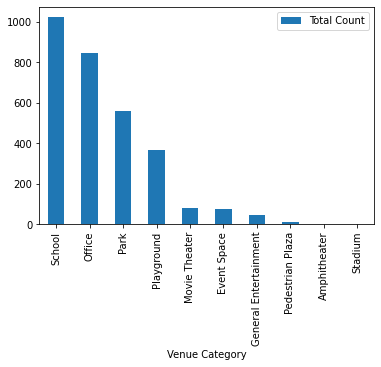

In [9]:
p= neighborhood_venues['Category'].value_counts().to_frame(name='Total Count')
p.index.name = 'Venue Category'
p.plot.bar(y='Total Count')


In [10]:
#check the number of venues for each neighborhood
df_groupby= neighborhood_venues.groupby('Neighborhood').count().reset_index()
df_groupby = df_groupby[['Neighborhood','Name']]
df_groupby= df_groupby.rename(columns={'Name':'VenueCount'})
df_groupby

,Neighborhood,VenueCount
0,ASTORIA,6
1,AUBURNDALE,6
2,BATH BEACH,9
3,BATTERY PARK CITY,56
4,BAY RIDGE,9
...,...,...
168,WINDSOR TERRACE,15
169,WOODHAVEN,8
170,WOODLAWN,2
171,WOODSIDE,16


In [11]:
# calculate the number of venus for each category for each neighborhood
neighborhood_venues_onehot = pd.get_dummies(neighborhood_venues[['Category']], prefix="", prefix_sep="")#one hot encoding
neighborhood_venues_onehot['Neighborhood'] = neighborhood_venues['Neighborhood'] 
fixed_columns = [neighborhood_venues_onehot.columns[-1]] + list(neighborhood_venues_onehot.columns[:-1])
neighborhood_venues_onehot = neighborhood_venues_onehot[fixed_columns]
neighborhood_venues_onehot = neighborhood_venues_onehot.groupby('Neighborhood').sum().reset_index() 
neighborhood_venues_onehot.head()

,Neighborhood,Amphitheater,Event Space,General Entertainment,Movie Theater,Office,Park,Pedestrian Plaza,Playground,School,Stadium
0,ASTORIA,0,1,0,0,0,2,0,2,1,0
1,AUBURNDALE,0,0,0,1,1,0,0,1,3,0
2,BATH BEACH,0,0,0,0,1,1,0,1,6,0
3,BATTERY PARK CITY,0,1,0,1,30,10,4,3,7,0
4,BAY RIDGE,0,0,0,1,3,1,0,2,2,0


In [144]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#find top 5 most common venues around each neighborhood
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues

columns =[ 'Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)

neighborhoods_venues_sorted['Neighborhood'] = neighborhood_venues_onehot['Neighborhood']


for ind in np.arange(neighborhood_venues_onehot.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neighborhood_venues_onehot.iloc[ind, :], num_top_venues)

#neighborhoods_venues_sorted['Average Rent'] = df_boston_nj['Average Rent']
neighborhoods_venues_sorted = pd.merge(neighborhoods_venues_sorted, df_groupby, how="left", left_on="Neighborhood", right_on="Neighborhood" )

neighborhoods_venues_sorted.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,VenueCount
0,ASTORIA,Playground,Park,School,Event Space,Stadium,6
1,AUBURNDALE,School,Playground,Office,Movie Theater,Stadium,6
2,BATH BEACH,School,Playground,Park,Office,Stadium,9
3,BATTERY PARK CITY,Office,Park,School,Pedestrian Plaza,Playground,56
4,BAY RIDGE,Office,School,Playground,Park,Movie Theater,9


In [22]:
ff_vn_categories = {
    
    'Fast Food Restaurant': '4bf58dd8d48988d16e941735'
}

ff_venues_csv = Path('./neighborhood_fastfood_venues.csv')
neighborhood_ff_venues = None

# check the venues data is explored and downloaded 
if( ff_venues_csv.exists() ):
    neighborhood_ff_venues = pd.read_csv('./neighborhood_fastfood_venues.csv')
else:    
    neighborhood_ff_venues = pd.DataFrame(columns=[ 'Category','Latitude', 'Longitude'])
    for name, lat, lng , avg_rent, name in zip(neighborhood_rent["areaName"], neighborhood_rent["latitude"], neighborhood_rent["longitude"], neighborhood_rent["avg_rent"], neighborhood_rent["areaName"]):
        for cat in ff_vn_categories:
            df = venues_nearby(lat, lng, cat, ff_vn_categories, name)
            df['Neighborhood'] = name
            df['Average Rent'] = avg_rent
            df['Category'] = cat
            neighborhood_ff_venues = neighborhood_ff_venues.append(df, sort=True)
    neighborhood_ff_venues.to_csv('neighborhood_fastfood_venues.csv', index=False)

neighborhood_ff_venues=neighborhood_ff_venues[["Neighborhood","Name"]].groupby("Neighborhood").count()  
neighborhood_ff_venues.rename(columns={"Name": "Fast Food Restaurant"}, inplace=True)
neighborhood_ff_venues.head(10)  

,Fast Food Restaurant
Neighborhood,
EAST HARLEM,1
MIDTOWN EAST,1
MIDTOWN SOUTH,1
NOLITA,1
NORWOOD,1
WILLIAMSBRIDGE,1


In [151]:
low_competitor = neighborhood_venues_onehot[~neighborhood_venues_onehot['Neighborhood'].isin(neighborhood_ff_venues.index)]

clustering_raw = pd.merge(low_competitor, df_groupby, how="left", left_on="Neighborhood", right_on="Neighborhood" )
clustering_raw = clustering_raw.drop('Neighborhood', 1)
clustering_raw = preprocessing.normalize(clustering_raw, norm='l2')


kclusters = 5 # set number of clusters


kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clustering_raw)

low_competitor.insert(0, 'Cluster Label', kmeans.labels_)

low_competitor= pd.merge(low_competitor, neighborhood_rent,how="left", left_on="Neighborhood", right_on="areaName" )

low_competitor.drop(labels=[ 'Borough', 'areaName'], axis= 1, inplace=True)
low_competitor.head()


,Cluster Label,Neighborhood,Amphitheater,Event Space,General Entertainment,Movie Theater,Office,Park,Pedestrian Plaza,Playground,School,Stadium,avg_rent,latitude,longitude
0,4,ASTORIA,0,1,0,0,0,2,0,2,1,0,1954.833333,40.772015,-73.930267
1,1,AUBURNDALE,0,0,0,1,1,0,0,1,3,0,1600.000000,40.761452,-73.789724
2,2,BATH BEACH,0,0,0,0,1,1,0,1,6,0,1647.571429,40.601850,-74.000501
3,0,BATTERY PARK CITY,0,1,0,1,30,10,4,3,7,0,3679.916667,40.711017,-74.016937
4,0,BAY RIDGE,0,0,0,1,3,1,0,2,2,0,1726.750000,40.633993,-74.014584


In [152]:
#visualize the clustered neighborhoods of boston
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)



# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(low_competitor['latitude'], low_competitor['longitude'], low_competitor['Neighborhood'], low_competitor['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [153]:
neighborhoods_venues_sorted_cluster= pd.merge(neighborhoods_venues_sorted, low_competitor, how='left', left_on='Neighborhood', right_on = 'Neighborhood')

neighborhoods_venues_sorted_cluster = neighborhoods_venues_sorted_cluster.drop(neighborhoods_venues_sorted_cluster.columns[range(8,18)], axis=1)

neighborhoods_venues_sorted_cluster

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,VenueCount,Cluster Label,avg_rent,latitude,longitude
0,ASTORIA,Playground,Park,School,Event Space,Stadium,6,4.0,1954.833333,40.772015,-73.930267
1,AUBURNDALE,School,Playground,Office,Movie Theater,Stadium,6,1.0,1600.000000,40.761452,-73.789724
2,BATH BEACH,School,Playground,Park,Office,Stadium,9,2.0,1647.571429,40.601850,-74.000501
3,BATTERY PARK CITY,Office,Park,School,Pedestrian Plaza,Playground,56,0.0,3679.916667,40.711017,-74.016937
4,BAY RIDGE,Office,School,Playground,Park,Movie Theater,9,0.0,1726.750000,40.633993,-74.014584
...,...,...,...,...,...,...,...,...,...,...,...
168,WINDSOR TERRACE,Park,School,Playground,Office,Stadium,15,3.0,2364.500000,40.655785,-73.976544
169,WOODHAVEN,School,Park,General Entertainment,Stadium,Playground,8,2.0,1736.500000,40.689270,-73.857913
170,WOODLAWN,School,Office,Stadium,Playground,Pedestrian Plaza,2,0.0,1708.324444,40.895753,-73.862452
171,WOODSIDE,School,Park,Office,Playground,Event Space,16,1.0,1789.500000,40.745380,-73.905415


In [154]:
neighborhoods_venues_sorted_cluster[neighborhoods_venues_sorted_cluster['Cluster Label'] == 0].sort_values(['avg_rent'], ascending=True).head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,VenueCount,Cluster Label,avg_rent,latitude,longitude
14,BOROUGH PARK,Office,Playground,Park,School,Stadium,9,0.0,1628.363636,40.633993,-73.996806
170,WOODLAWN,School,Office,Stadium,Playground,Pedestrian Plaza,2,0.0,1708.324444,40.895753,-73.862452
160,WAKEFIELD,School,Park,Office,Stadium,Playground,3,0.0,1708.324444,40.906197,-73.855511
41,COUNTRY CLUB,School,Office,Stadium,Playground,Pedestrian Plaza,2,0.0,1708.324444,40.839167,-73.819722
4,BAY RIDGE,Office,School,Playground,Park,Movie Theater,9,0.0,1726.750000,40.633993,-74.014584


In [155]:
neighborhoods_venues_sorted_cluster[neighborhoods_venues_sorted_cluster['Cluster Label'] == 1].sort_values(['avg_rent'], ascending=True).head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,VenueCount,Cluster Label,avg_rent,latitude,longitude
64,FORDHAM,School,Park,Office,Playground,Event Space,22,1.0,1591.000000,40.861475,-73.890544
1,AUBURNDALE,School,Playground,Office,Movie Theater,Stadium,6,1.0,1600.000000,40.761452,-73.789724
137,ROCKAWAY ALL,School,Playground,Stadium,Pedestrian Plaza,Park,5,1.0,1661.083333,40.581533,-73.830110
48,DYKER HEIGHTS,School,Playground,Office,Stadium,Pedestrian Plaza,4,1.0,1662.500000,40.620472,-74.011667
164,WESTCHESTER VILLAGE,School,Playground,Stadium,Pedestrian Plaza,Park,5,1.0,1708.324444,40.830954,-73.869524


In [156]:
neighborhoods_venues_sorted_cluster[neighborhoods_venues_sorted_cluster['Cluster Label'] == 2].sort_values(['avg_rent'], ascending=True).head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,VenueCount,Cluster Label,avg_rent,latitude,longitude
53,EAST TREMONT,School,Park,Office,Playground,Stadium,15,2.0,1575.000000,40.845378,-73.890969
20,BROWNSVILLE,School,Office,Event Space,Stadium,Playground,14,2.0,1612.333333,40.660937,-73.920137
155,UNIVERSITY HEIGHTS,School,Playground,Park,Stadium,Pedestrian Plaza,6,2.0,1614.800000,40.861841,-73.913515
11,BENSONHURST,School,Stadium,Playground,Pedestrian Plaza,Park,5,2.0,1631.916667,40.604977,-73.993406
17,BRONXWOOD,School,Playground,Park,Stadium,Pedestrian Plaza,9,2.0,1643.250000,40.883520,-73.856073


In [157]:
neighborhoods_venues_sorted_cluster[neighborhoods_venues_sorted_cluster['Cluster Label'] == 3].sort_values(['avg_rent'], ascending=True).head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,VenueCount,Cluster Label,avg_rent,latitude,longitude
153,TREMONT,Park,School,Playground,Stadium,Pedestrian Plaza,8,3.0,1658.166667,40.846896,-73.899755
7,BEDFORD PARK,Park,Playground,Office,School,General Entertainment,14,3.0,1688.400000,40.870100,-73.885691
152,THROGS NECK,Park,School,Stadium,Playground,Pedestrian Plaza,5,3.0,1708.324444,40.822601,-73.819578
81,HUNTS POINT,Park,School,Office,Stadium,Playground,6,3.0,1708.324444,40.812601,-73.884025
42,CROTONA PARK EAST,Park,Playground,School,Stadium,Pedestrian Plaza,16,3.0,1708.324444,40.836601,-73.892962


In [158]:
neighborhoods_venues_sorted_cluster[neighborhoods_venues_sorted_cluster['Cluster Label'] == 4].sort_values(['avg_rent'], ascending=True).head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,VenueCount,Cluster Label,avg_rent,latitude,longitude
123,PELHAM BAY,Playground,Office,Stadium,School,Pedestrian Plaza,4,4.0,1708.324444,40.850556,-73.833333
141,SHEEPSHEAD BAY,Playground,Park,Movie Theater,Stadium,School,7,4.0,1718.750000,40.591216,-73.944582
15,BRIARWOOD,School,Playground,Park,Stadium,Pedestrian Plaza,9,4.0,1727.166667,40.709256,-73.820139
44,DITMAS PARK,Playground,Park,School,Office,Stadium,6,4.0,1826.250000,40.637531,-73.963449
22,CAMBRIA HEIGHTS,School,Playground,Park,Stadium,Pedestrian Plaza,3,4.0,1882.602617,40.694547,-73.738465
